In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
import pickle

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [2]:
df_prot=pd.read_pickle('df_ruth.pkl')

"""
with fits.open('/Users/lucy/Desktop/FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
"""    
#Rvars=pd.read_pickle('Rvars.pkl')
#df_rvar_or=pd.merge(gaia,Rvars,left_on='kepid',right_on='KID',how='inner')


'\nwith fits.open(\'/Users/lucy/Desktop/FirstYearML/kepler_dr2_1arcsec.fits\') as data_ga:\n    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")\n'

In [3]:
len(gaia['kepid'].drop_duplicates(keep='first'))

NameError: name 'gaia' is not defined

In [ ]:
#df_rvar_or.loc[df_rvar_or['KID'].isin(kepids)]

In [ ]:
gaia.loc[gaia['kepid'].isin(kepids)]['kepid']

In [ ]:
df_prot=df_prot.loc[df_prot['Rvar']<5e4]

In [ ]:
df_rvar_or['flicker']=np.ones(len(df_rvar_or))
df_prot['flicker']=np.ones(len(df_prot))

In [10]:
import pickle
reg=pickle.load(open('/Users/lucy/Desktop/FirstYearML/Astraea/Astraea/data/RF_Regre_model_100est_flicker.sav','rb'))


In [11]:
TrainF_class, TrainF_reg = Astraea.getTrainF()

TrainF_reg=['teff_calc','bp_g','lum_val','v_t','phot_g_mean_flux_over_error',
            'v_b','radius_val','b','Rvar','flicker']

TrainF_reg_woflicker=['teff_calc','bp_g','lum_val','v_t','phot_g_mean_flux_over_error',
            'v_b','radius_val','b','Rvar']

TrainF_reg_nolc=['teff_calc','bp_g','lum_val','v_t','phot_g_mean_flux_over_error',
            'v_b','radius_val','b']

>>> classification features are: ['LG_peaks [Lomb-Scargle peak height]', 'Rvar [ppm]', 'parallax [gaia]', 'radius_percentile_lower [gaia]', 'radius_percentile_upper [gaia]', 'phot_g_mean_flux_over_error [gaia]', 'bp_g [gaia]']


>>> regression features are: ['teff [gaia]','bp_g [gaia]','lum_val [gaia]','v_tan [getVs()]','phot_g_mean_flux_over_error [gaia]','v_b [getVs()]','radius_val [gaia]','b [gaia]','Rvar [ppm]','flicker [FLICKER]']




In [12]:
from dustmaps.bayestar import BayestarQuery
bayestar = BayestarQuery(max_samples=2, version='bayestar2019')
print("Calculating Ebv")

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 34.589 s
  pix_info:   0.647 s
   samples:  15.553 s
      best:   7.205 s
       nan:   0.333 s
      sort:  10.693 s
       idx:   0.159 s
Calculating Ebv


In [13]:
# calculate v_b's
df_rvar_or['v_t'],df_rvar_or['v_b']=Astraea.getVs(df_rvar_or)

/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:90: RuntimeWarning: invalid value encountered in less
  d[d < 0] = np.nan
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/lucy/anaconda3/lib/pytho

In [14]:
def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp

In [15]:
import astropy.units as units
coords = SkyCoord(df_rvar_or.ra.values*units.deg, df_rvar_or.dec.values*units.deg,
                  distance=df_rvar_or.r_est.values*units.pc)
ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.],
                      return_flags=True)
# Calculate Av
Av_bayestar = 2.742 * ebv
print(np.shape(Av_bayestar), "shape")
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

df_rvar_or["ebv"] = ebv[:, 1]  # The median ebv value.
df_rvar_or["Av"] = Av
df_rvar_or["Av_errp"] = Av_errp
df_rvar_or["Av_errm"] = Av_errm
df_rvar_or["Av_std"] = Av_std

# Calculate dereddened photometry
AG, Abp, Arp = getDust(df_rvar_or.phot_g_mean_mag.values,
                       df_rvar_or.phot_bp_mean_mag.values,
                       df_rvar_or.phot_rp_mean_mag.values, df_rvar_or.ebv.values)
df_rvar_or["bp_dered"] = df_rvar_or.phot_bp_mean_mag.values - Abp
df_rvar_or["rp_dered"] = df_rvar_or.phot_rp_mean_mag.values - Arp
df_rvar_or["bprp_dered"] = df_rvar_or["bp_dered"] - df_rvar_or["rp_dered"]
df_rvar_or["G_dered"] = df_rvar_or.phot_g_mean_mag.values - AG

/Users/lucy/anaconda3/lib/python3.7/site-packages/dustmaps/bayestar.py:69: RuntimeWarning: invalid value encountered in greater_equal
  idx = (b >= -90.) & (b <= 90.)
/Users/lucy/anaconda3/lib/python3.7/site-packages/dustmaps/bayestar.py:69: RuntimeWarning: invalid value encountered in less_equal
  idx = (b >= -90.) & (b <= 90.)
/Users/lucy/anaconda3/lib/python3.7/site-packages/dustmaps/bayestar.py:500: RuntimeWarning: invalid value encountered in greater_equal
  np.isfinite(dm_min) &
/Users/lucy/anaconda3/lib/python3.7/site-packages/dustmaps/bayestar.py:500: RuntimeWarning: invalid value encountered in less_equal
  np.isfinite(dm_min) &
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


(195605, 3) shape


In [16]:
import numpy as np


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
             -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
             301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10


In [17]:
# for all Kepler stars
df_rvar_or["teff_calc"]=bprp_to_teff(df_rvar_or["bprp_dered"])
#df_rvar.to_pickle('AllRvarsKeplerGaia.pkl')
#df_rvar_or=df_rvar_or.dropna(subset=regr_outs['actrualF'])
df_rvar_or["abs_G"] = m_to_M(df_rvar_or['G_dered'], 1./df_rvar_or.parallax.values)


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10


In [18]:
kepids=[5342558,7732146,11822514,12456401,11075611]
df_rvar_or.loc[df_rvar_or['KID'].isin(kepids)][regr_outs['actrualF']]

NameError: name 'regr_outs' is not defined

In [417]:
x=df_rvar_or.loc[df_rvar_or['abs_G']>4].drop_duplicates(subset='kepid',keep='first')
x.loc[x['Rvar']<5e4]

,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,...,Av,Av_errp,Av_errm,Av_std,bp_dered,rp_dered,bprp_dered,G_dered,teff_calc,abs_G
4,1.635721e+18,Gaia DR2 2050231848829944320,2.050232e+18,2.980325e+08,2015.5,291.137620,0.019560,36.577344,0.025196,1.168913,...,0.383880,0.018646,0.018646,0.018646,15.240799,14.264825,0.975974,14.829724,5313.795979,5.168635
9,1.635721e+18,Gaia DR2 2050234735047928320,2.050235e+18,1.565764e+09,2015.5,291.021663,0.011937,36.643648,0.016227,2.050222,...,0.164520,0.000000,0.000000,0.000000,13.942863,12.961166,0.981697,13.523203,5297.840063,5.082208
10,1.635721e+18,Gaia DR2 2050236521754360832,2.050237e+18,1.033231e+09,2015.5,291.024101,0.011912,36.695306,0.015535,1.771674,...,0.123390,0.009323,0.009323,0.009323,13.731164,12.865838,0.865326,13.372126,5639.917171,4.614045
11,1.635721e+18,Gaia DR2 2050233940470191872,2.050234e+18,1.444712e+09,2015.5,291.063824,0.269798,36.635671,0.391992,3.008085,...,0.041130,0.009323,0.009323,0.009323,14.841850,12.854084,1.987765,13.857812,3783.045568,6.249263
13,1.635721e+18,Gaia DR2 2050232329866320512,2.050232e+18,1.535619e+09,2015.5,291.128433,0.010596,36.639033,0.013696,1.681389,...,0.187527,0.015645,0.015645,0.015645,13.508328,12.755823,0.752505,13.207404,5987.826728,4.335745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195591,1.635721e+18,Gaia DR2 2139336408576560512,2.139336e+18,1.389496e+09,2015.5,289.921973,0.021650,52.406373,0.022294,0.787841,...,0.281327,0.013799,0.013799,0.013799,15.346218,14.382293,0.963925,14.936403,5347.731327,4.418595
195593,1.635721e+18,Gaia DR2 2139336099338925312,2.139336e+18,2.699998e+08,2015.5,289.964228,0.023087,52.424308,0.025331,0.669294,...,0.315330,0.009323,0.009323,0.009323,15.236818,14.502978,0.733841,14.948032,6043.922841,4.076116
195594,1.635721e+18,Gaia DR2 2139341768695774336,2.139342e+18,1.626857e+09,2015.5,290.033980,0.031699,52.439817,0.030193,1.052836,...,0.246780,0.018646,0.018646,0.018646,16.027684,14.949110,1.078574,15.558916,5044.668752,5.670720
195595,1.635721e+18,Gaia DR2 2139341906134738432,2.139342e+18,2.558871e+08,2015.5,290.058448,0.026208,52.453856,0.026837,0.807338,...,0.274200,0.000000,0.000000,0.000000,15.708975,14.730165,0.978811,15.316444,5305.874615,4.851720


In [418]:
df_prot.loc[df_prot['abs_G']>4]

,KID,Teff,logg_x,Mass,Prot,Prot_err,LPH,w,DC,solution_id,...,dv_MAD,dv_STD,dv_MAD_err,age_STD,vd,vd_err,Rvar,age,age_err,flicker
1,1026474,4122,4.56,0.5914,1.569,0.006,1.204,0.6061,0,1.635721e+18,...,23.995260,20.423772,0.378959,6.030264,42.239950,17.949421,67562.371492,10.327774,18.157580,1.0
2,1164102,4045,4.62,0.5606,31.496,0.474,0.568,0.3939,0,1.635721e+18,...,26.023469,21.573628,0.029400,6.362462,23.388488,0.803326,2368.494868,5.917678,0.789759,1.0
4,1297303,4296,4.61,0.6613,27.333,0.193,0.777,0.5124,0,1.635721e+18,...,21.475267,17.909883,0.036277,5.254363,17.428481,0.648533,6550.490856,4.485449,0.615615,1.0
5,1429921,4217,4.72,0.6295,23.131,0.110,0.943,0.5839,0,1.635721e+18,...,19.243612,16.390262,0.012694,4.746714,17.655728,1.468746,14834.702015,4.540526,1.414068,1.0
6,1430349,4285,4.54,0.6569,34.717,0.752,0.376,0.2563,0,1.635721e+18,...,26.458044,22.301478,0.013907,6.566238,20.104665,1.237065,2209.275961,5.131577,1.316054,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21365,12644900,6056,4.54,1.1243,11.187,2.421,0.249,0.2070,0,1.635721e+18,...,13.466565,12.100812,0.050805,3.103098,9.426865,0.554362,1584.625244,2.514019,0.562769,1.0
21366,12645046,5763,4.70,1.0371,20.996,3.081,0.313,0.2283,0,1.635721e+18,...,15.195264,13.090122,0.044626,3.515310,12.360775,0.338658,1819.634438,3.245133,0.323862,1.0
21367,12735784,5166,4.58,0.8772,26.979,3.521,0.312,0.2054,0,1.635721e+18,...,17.796768,15.180218,0.004998,4.317794,14.406367,0.580351,3754.758835,3.748780,0.580349,1.0
21368,12884110,4948,4.72,0.8208,10.600,0.141,0.391,0.2042,0,1.635721e+18,...,11.491409,10.623249,0.027267,2.439927,8.121565,0.377990,3635.424376,2.184686,0.380954,1.0


Text(0.5, 1.0, 'logg')

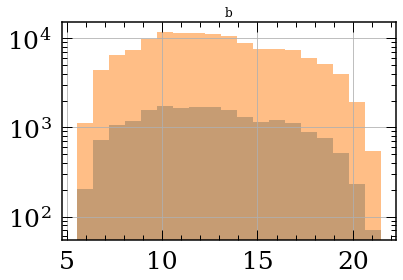

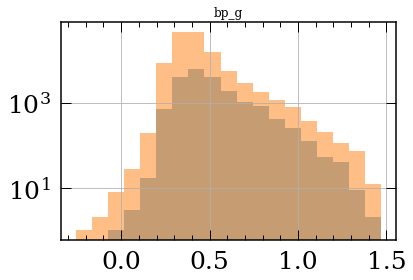

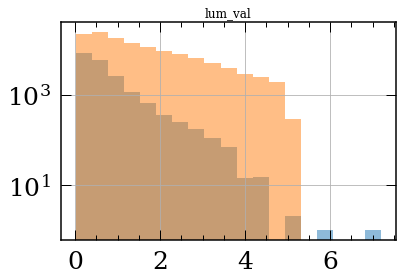

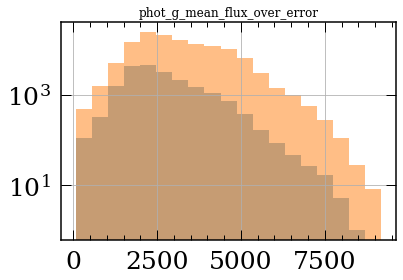

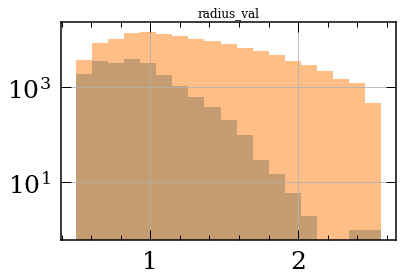

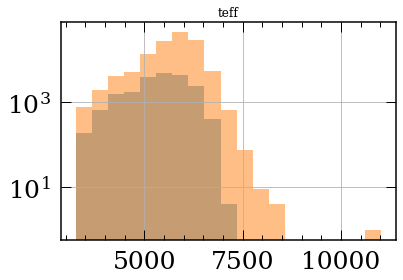

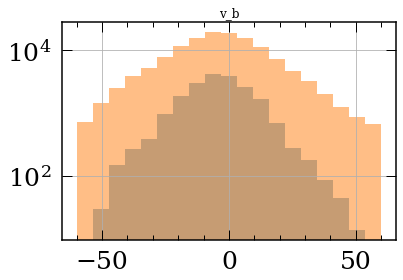

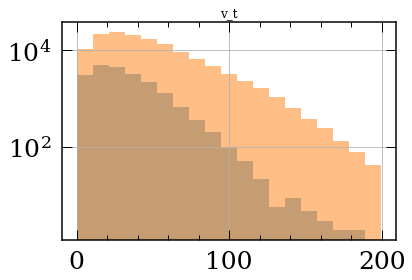

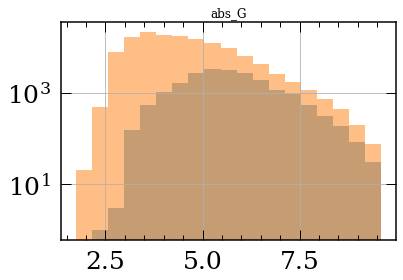

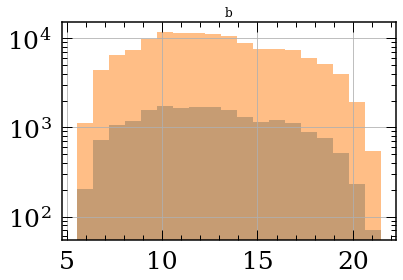

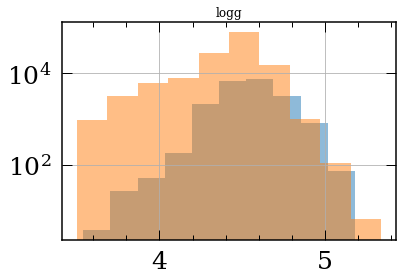

In [34]:


#df_rvar=df_rvar_or.loc[df_rvar_or['abs_G']>4]
df_rvar=df_rvar_or.loc[df_rvar_or['radius_val']<2.5]
#df_rvar=df_rvar.loc[df_rvar['teff_calc']>3000]
#df_rvar=df_rvar.loc[df_rvar['teff_calc']<10000]
df_rvar=df_rvar.loc[df_rvar['Rvar']<5e4]
df_rvar=df_rvar.loc[df_rvar['logg']>3.5]
df_rvar=df_rvar.loc[df_rvar['v_t']<200]
df_rvar=df_rvar.loc[df_rvar['lum_val']<5]
df_rvar=df_rvar.loc[abs(df_rvar['v_b'])<60]
#df_rvar=df_rvar.loc[abs(df_rvar['v_b'])<50]

df_rvar=df_rvar.dropna(subset=['radius_val','lum_val'])
df_prot=df_prot.dropna(subset=['radius_val','lum_val'])

for i in np.append(regr_outs['actrualF'],['abs_G','b']):
    plt.figure()
    minbinsize=min(np.append(df_prot[i].values,df_rvar[i].values))
    maxbinsize=max(np.append(df_prot[i].values,df_rvar[i].values))
    bins=np.linspace(minbinsize,maxbinsize,20)
    df_prot[i].hist(alpha=0.5,bins=bins)
    df_rvar[i].hist(alpha=0.5,bins=bins)
    plt.yscale('log')
    plt.title(i)

plt.figure()
df_prot['logg_x'].hist(alpha=0.5)
df_rvar['logg'].hist(alpha=0.5)
plt.yscale('log')
plt.title('logg')

In [422]:
df_rvar.drop_duplicates(subset='kepid')

,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,...,Av,Av_errp,Av_errm,Av_std,bp_dered,rp_dered,bprp_dered,G_dered,teff_calc,abs_G
4,1.635721e+18,Gaia DR2 2050231848829944320,2.050232e+18,2.980325e+08,2015.5,291.137620,0.019560,36.577344,0.025196,1.168913,...,0.383880,0.018646,0.018646,0.018646,15.240799,14.264825,0.975974,14.829724,5313.795979,5.168635
10,1.635721e+18,Gaia DR2 2050236521754360832,2.050237e+18,1.033231e+09,2015.5,291.024101,0.011912,36.695306,0.015535,1.771674,...,0.123390,0.009323,0.009323,0.009323,13.731164,12.865838,0.865326,13.372126,5639.917171,4.614045
11,1.635721e+18,Gaia DR2 2050233940470191872,2.050234e+18,1.444712e+09,2015.5,291.063824,0.269798,36.635671,0.391992,3.008085,...,0.041130,0.009323,0.009323,0.009323,14.841850,12.854084,1.987765,13.857812,3783.045568,6.249263
13,1.635721e+18,Gaia DR2 2050232329866320512,2.050232e+18,1.535619e+09,2015.5,291.128433,0.010596,36.639033,0.013696,1.681389,...,0.187527,0.015645,0.015645,0.015645,13.508328,12.755823,0.752505,13.207404,5987.826728,4.335745
16,1.635721e+18,Gaia DR2 2050232364226074624,2.050232e+18,1.045593e+09,2015.5,291.141664,0.030849,36.648235,0.033753,1.123321,...,0.246780,0.018646,0.018646,0.018646,16.142554,15.069564,1.072990,15.685258,5058.354128,5.937777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195591,1.635721e+18,Gaia DR2 2139336408576560512,2.139336e+18,1.389496e+09,2015.5,289.921973,0.021650,52.406373,0.022294,0.787841,...,0.281327,0.013799,0.013799,0.013799,15.346218,14.382293,0.963925,14.936403,5347.731327,4.418595
195593,1.635721e+18,Gaia DR2 2139336099338925312,2.139336e+18,2.699998e+08,2015.5,289.964228,0.023087,52.424308,0.025331,0.669294,...,0.315330,0.009323,0.009323,0.009323,15.236818,14.502978,0.733841,14.948032,6043.922841,4.076116
195594,1.635721e+18,Gaia DR2 2139341768695774336,2.139342e+18,1.626857e+09,2015.5,290.033980,0.031699,52.439817,0.030193,1.052836,...,0.246780,0.018646,0.018646,0.018646,16.027684,14.949110,1.078574,15.558916,5044.668752,5.670720
195595,1.635721e+18,Gaia DR2 2139341906134738432,2.139342e+18,2.558871e+08,2015.5,290.058448,0.026208,52.453856,0.026837,0.807338,...,0.274200,0.000000,0.000000,0.000000,15.708975,14.730165,0.978811,15.316444,5305.874615,4.851720


## Without Rvar

In [377]:
df_prot=df_prot.dropna(subset=TrainF_reg)
df_rvar=df_rvar.dropna(subset=TrainF_reg)

predictions=reg.predict(df_prot[TrainF_reg].values)



In [378]:
# Train
regr, regr_outs = Astraea.RFregressor(df_prot, TrainF_reg_nolc,
                                      target_var='Prot_err', target_var_err='Prot_err', n_estimators=60)

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 8
Features attempt to train: ['teff_calc', 'bp_g', 'lum_val', 'v_t', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b']
20304 stars in dataframe!
20304 total stars used for RF!
16243 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 2.31154177433247
Average chi^2 is: 11.072887994244311
Finished!


/Users/lucy/anaconda3/lib/python3.7/site-packages/Astraea-0.1.0-py3.7.egg/Astraea/Astraea.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  meree=np.median([abs(TrueVal[i]-PreVal[i])/TrueVal[i] for i in range(len(TrueVal))])


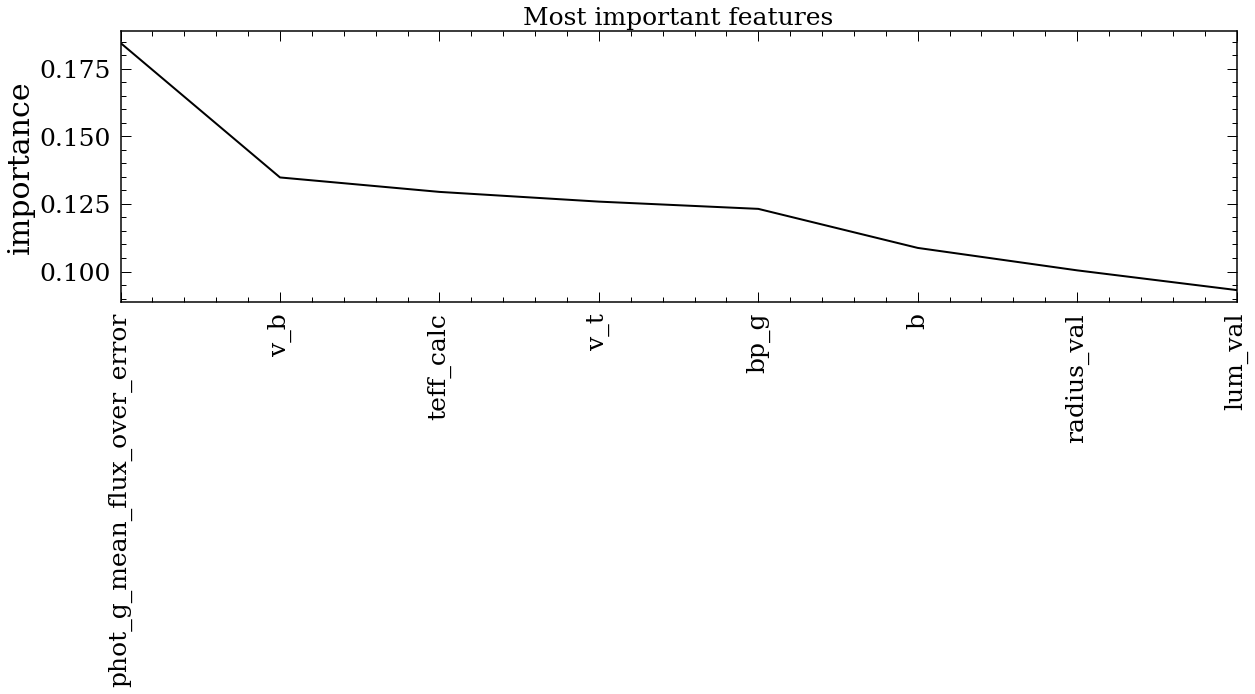

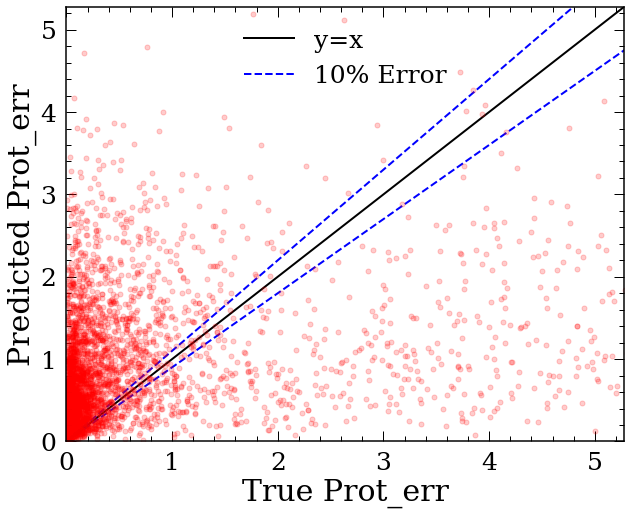

In [379]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Prot_err', MS=10)

In [310]:


df_prot=df_prot.dropna(subset=regr_outs['actrualF'])
predictions=regr.predict(df_prot[regr_outs['actrualF']].values)
df_prot['predictedProt']=predictions

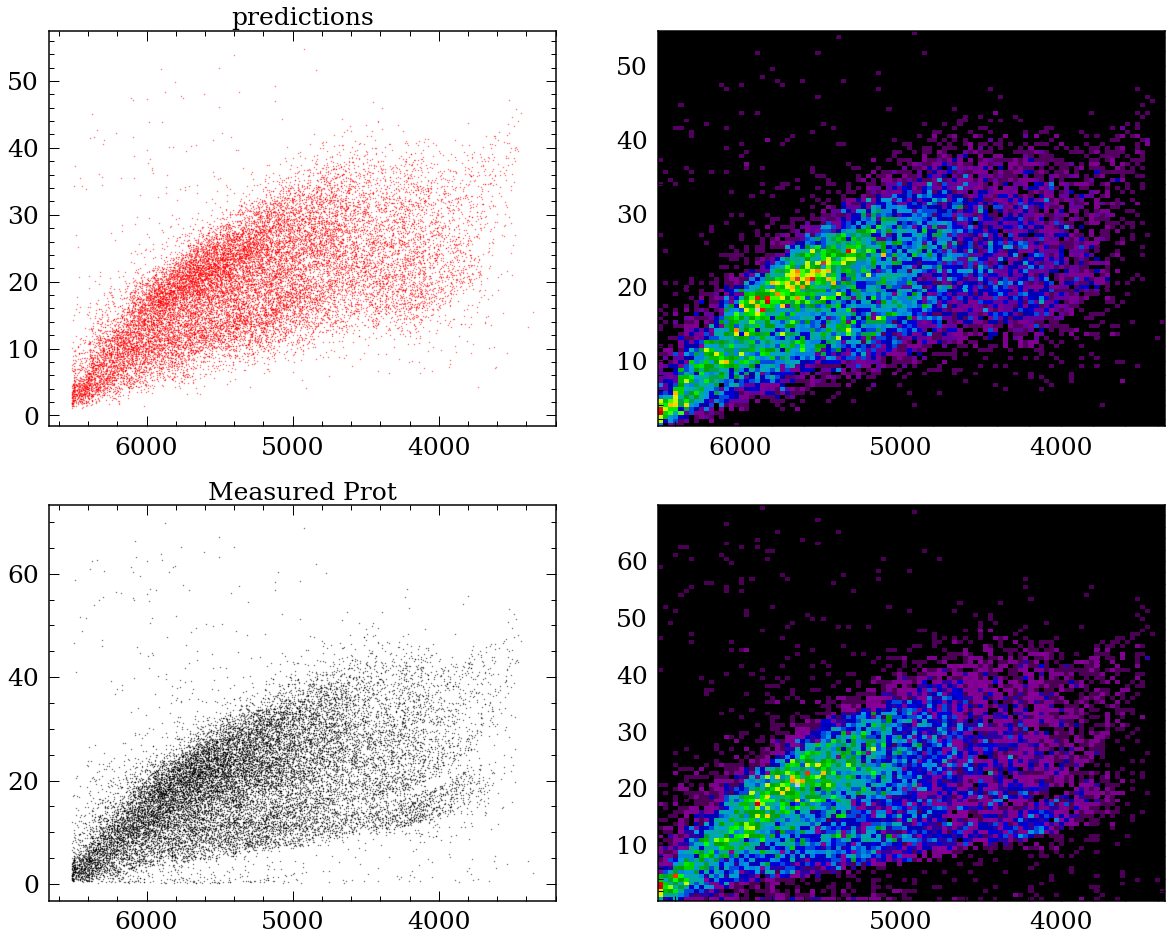

In [311]:
plt.figure(figsize=(20,16))
plt.subplot(2,2,1)
plt.plot(df_prot.teff_calc,df_prot.predictedProt,'r.',alpha=0.5,markersize=1)
plt.gca().invert_xaxis()
plt.title('predictions',fontsize=25)
plt.subplot(2,2,2)
plt.hist2d(df_prot.teff_calc,df_prot.predictedProt,bins =100,cmap = plt.cm.nipy_spectral)
plt.gca().invert_xaxis()

#plt.figure(figsize=(20,16))
plt.subplot(2,2,3)
plt.plot(df_prot.teff_calc,df_prot.Prot,'k.',alpha=0.5,markersize=1)
plt.gca().invert_xaxis()
plt.title('Measured Prot',fontsize=25)
plt.subplot(2,2,4)
plt.hist2d(df_prot.teff_calc,df_prot.Prot,bins =100,cmap = plt.cm.nipy_spectral)
plt.gca().invert_xaxis()

#df_prot.to_pickle('/Users/lucy/Desktop/FirstYearML/Figures/df_prot')


plt.savefig('AstraeaMcQuillan_woRvar.png')

In [312]:
predictions_rvar=regr.predict(df_rvar[regr_outs['actrualF']].values)

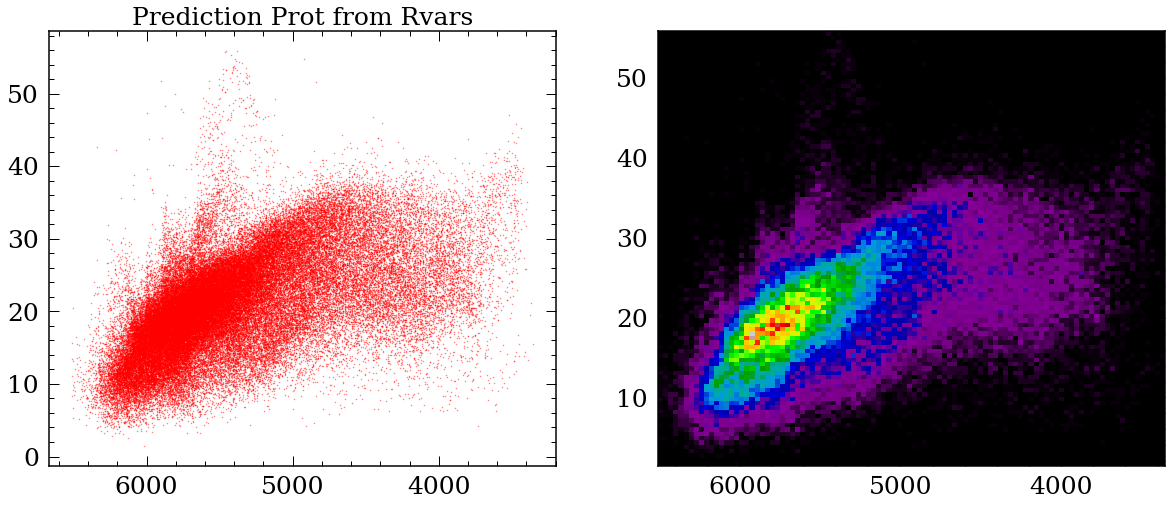

In [313]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df_rvar.teff_calc,predictions_rvar,'r.',alpha=0.5,markersize=1)
plt.gca().invert_xaxis()
plt.title('Prediction Prot from Rvars',fontsize=25)
plt.subplot(1,2,2)
plt.hist2d(df_rvar.teff_calc,predictions_rvar,bins =100,cmap = plt.cm.nipy_spectral)
plt.gca().invert_xaxis()

plt.savefig('AstraeaMcQuillan_woRvar_allstars.png')

Text(0, 0.5, 'v_b [km/s]')

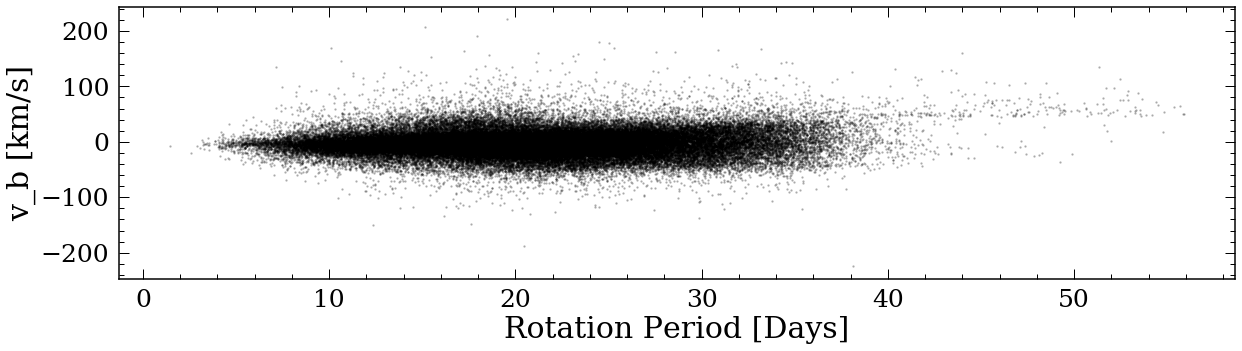

In [314]:
plt.figure(figsize=(20,5))
plt.plot(predictions_rvar,df_rvar['v_b'],'k.',alpha=0.2,markersize=3)
plt.xlabel('Rotation Period [Days]')
plt.ylabel('v_b [km/s]')

## With Rvar

In [39]:
#df_rvar_or.to_pickle('KinageAllKepler.pkl')

In [41]:
df_prot=pd.merge(df_prot,Rvars,left_on='KID',right_on='KID',how='inner')
df_prot=pd.merge(df_prot,df_rvar_or[['teff_calc','KID']],left_on='KID',right_on='KID',how='inner')

In [42]:
# Train
trainid=np.load('../FirstYearML/trainKID.npy')
testid=np.load('../FirstYearML/testKID.npy')
regr, regr_outs = Astraea.RFregressor(df_prot, TrainF_reg_woflicker,X_train_ind=trainid,X_test_ind=testid,
                                      target_var='Prot_err', target_var_err='Prot_err', n_estimators=60)

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Training KID specified!

Estimated fraction of data used to train: 0.695358757241994
# of Features attempt to train: 9
Features attempt to train: ['teff_calc', 'bp_g', 'lum_val', 'v_t', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Rvar']
31414 stars in dataframe!
Missing 1003 stars from null values in data!

30411 total stars used for RF!
21287 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 1.1609195402298853
Average chi^2 is: 6.585879311094815
Finished!


/Users/lucy/anaconda3/lib/python3.7/site-packages/Astraea-0.1.0-py3.7.egg/Astraea/Astraea.py:315: RuntimeWarning: divide by zero encountered in double_scalars
  meree=np.median([abs(TrueVal[i]-PreVal[i])/TrueVal[i] for i in range(len(TrueVal))])


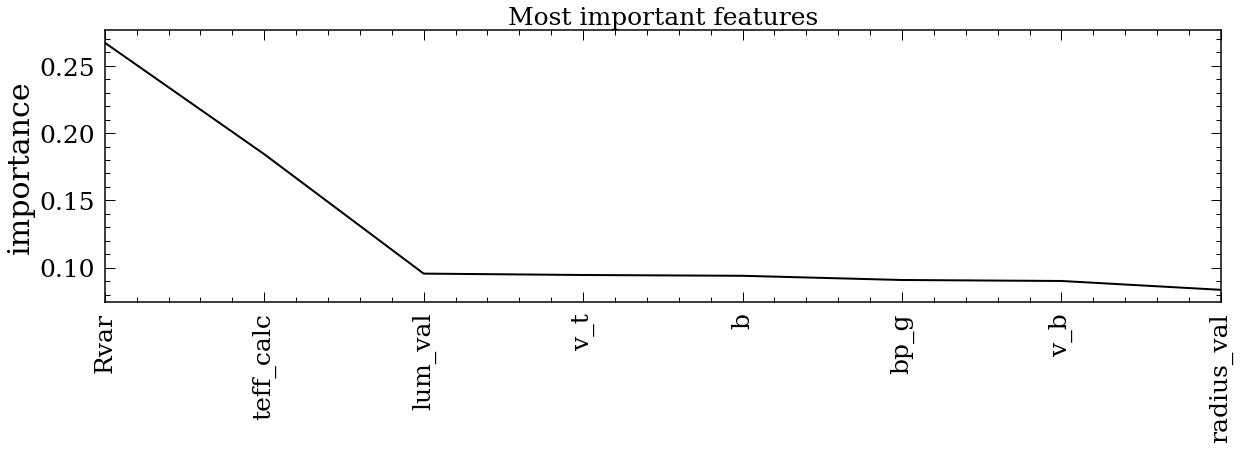

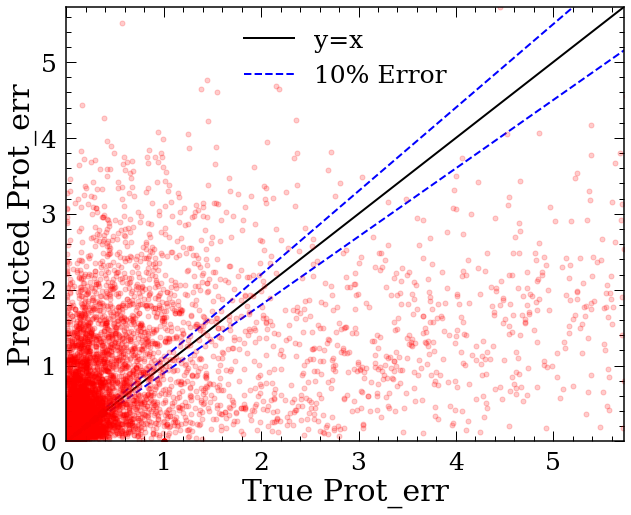

In [43]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Prot_err', MS=10)

In [105]:
regr=pickle.load(open('./regressor.sav','rb'))
regr_outs=pd.read_pickle('regressor_features.pkl')
print(regr_outs['actrualF'])
regr_outs['actrualF']=['bp_g', 'lum_val', 'v_t', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Rvar', 'teff_calc']


['bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Rvar', 'teff_calc']


In [79]:
df_prot=pd.merge(df_prot,gaia[['kepid','phot_g_mean_flux_over_error']])

In [106]:
df_prot[regr_outs['actrualF']]


,bp_g,lum_val,v_t,phot_g_mean_flux_over_error,v_b,radius_val,b,Rvar,teff_calc
0,0.759875,0.106358,17.702679,1289.267822,15.602643,0.643526,9.776886,0.067562,4026.558638
1,0.965142,0.141936,20.490185,1714.262573,-11.929150,0.858647,9.680972,0.007981,3892.908102
2,0.842219,0.101037,17.989548,2412.074463,13.596025,0.589280,9.468968,0.002368,4048.484918
3,0.710743,0.146520,22.581097,2031.734131,16.651520,0.641972,9.323731,0.006550,4316.554097
4,0.755245,0.130948,18.227238,1336.526978,-6.969535,0.663087,10.159101,0.014835,4252.863132
...,...,...,...,...,...,...,...,...,...
30733,0.338387,1.040298,24.194717,2568.563232,3.793384,1.010998,17.135302,0.017143,5959.030161
30734,0.365394,1.747653,12.894025,1004.101257,12.807173,1.535321,17.133349,0.002153,5770.633278
30735,0.574278,0.226113,64.961322,2504.332520,8.648168,0.621510,17.151246,0.003264,4750.924050
30736,0.457419,0.444259,59.579629,2527.859375,-1.165221,0.865647,17.125108,0.004038,5282.823374


In [83]:
#df_prot['Rvar']=df_prot['Rvar']/1e6
df_prot=df_prot.dropna(subset=regr_outs['actrualF'])
predictions=regr.predict(df_prot[regr_outs['actrualF']].values)
df_prot['predictedProt']=predictions

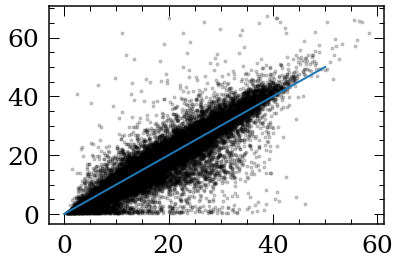

In [84]:
#plt.figure(figsize=(10,8))
plt.plot(df_prot['predictedProt'],df_prot['Prot'],'k.',alpha=0.2)
plt.plot([0,50],[0,50])

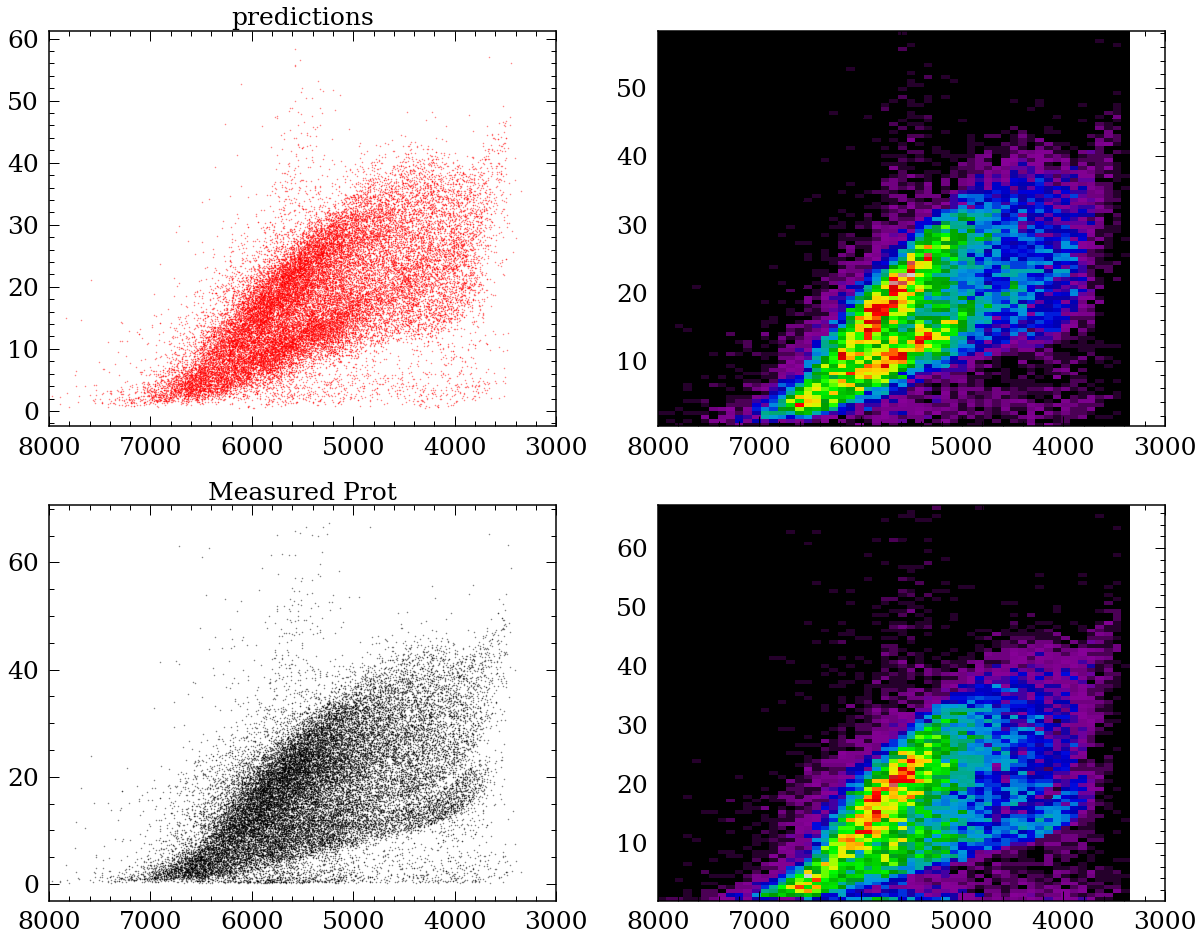

In [87]:
plt.figure(figsize=(20,16))
plt.subplot(2,2,1)
plt.plot(df_prot.teff_calc,df_prot.predictedProt,'r.',alpha=0.5,markersize=1)
plt.gca().invert_xaxis()
plt.xlim([8000,3000])
plt.title('predictions',fontsize=25)
plt.subplot(2,2,2)
plt.hist2d(df_prot.teff_calc,df_prot.predictedProt,bins =100,cmap = plt.cm.nipy_spectral)
plt.gca().invert_xaxis()
plt.xlim([8000,3000])

#plt.figure(figsize=(20,16))
plt.subplot(2,2,3)
plt.plot(df_prot.teff_calc,df_prot.Prot,'k.',alpha=0.5,markersize=1)
plt.gca().invert_xaxis()
plt.xlim([8000,3000])
plt.title('Measured Prot',fontsize=25)
plt.subplot(2,2,4)
plt.hist2d(df_prot.teff_calc,df_prot.Prot,bins =100,cmap = plt.cm.nipy_spectral)
plt.gca().invert_xaxis()
plt.xlim([8000,3000])
df_prot.to_pickle('newProt.pkl')


plt.savefig('AstraeaMcQuillan_wRvar.png')

In [133]:
df_rvar=pd.read_pickle('KinageAllKepler.pkl')
df_rvar=df_rvar.dropna(subset=regr_outs['actrualF'])
df_prot=pd.read_pickle('Prots.pkl')
df_prot['v_t']=df_prot['v_tan']
df_prot=pd.merge(df_prot,df_rvar[['kepid','logg','abs_G']],left_on='KID',right_on='kepid',how='inner')

In [123]:
df_prot

,bp_g,lum_val,v_tan,phot_g_mean_flux_over_error,v_b,radius_val,b,Rvar,teff_calc,v_t
0,0.759875,0.106358,17.702679,1289.267822,15.602643,0.643526,9.776886,67562.371492,4026.558638,17.702679
1,0.842219,0.101037,17.989548,2412.074463,13.596025,0.589280,9.468968,2368.494868,4048.484918,17.989548
2,0.710743,0.146520,22.581097,2031.734131,16.651520,0.641972,9.323731,6550.490856,4316.554097,22.581097
3,0.755245,0.130948,18.227238,1336.526978,-6.969535,0.663087,10.159101,14834.702015,4252.863132,18.227238
4,0.690351,0.141079,31.422740,2262.149902,12.197629,0.632776,10.053180,2209.275961,4369.082167,31.422740
...,...,...,...,...,...,...,...,...,...,...
29486,0.496054,0.323039,102.530271,4705.781250,26.590903,0.774447,16.802680,827.217102,4957.823084,102.530271
29487,0.502046,0.342173,3.229439,2252.542969,-1.212178,0.780888,17.246058,3635.424376,5122.906288,3.229439
29488,0.773923,0.124440,68.123474,2518.176758,-35.372596,0.633548,17.163879,2398.994565,4163.624695,68.123474
29489,0.574546,0.311295,8.393855,2239.851074,6.894063,0.825301,16.913496,3058.016300,4913.201762,8.393855


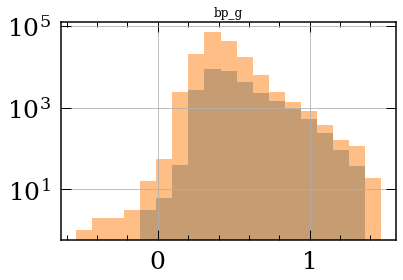

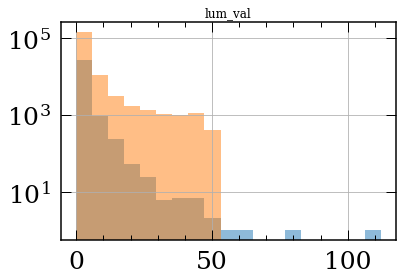

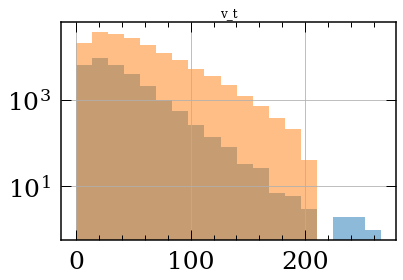

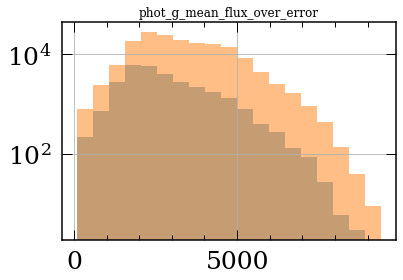

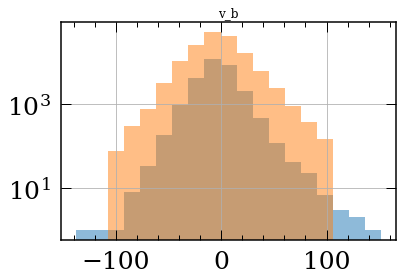

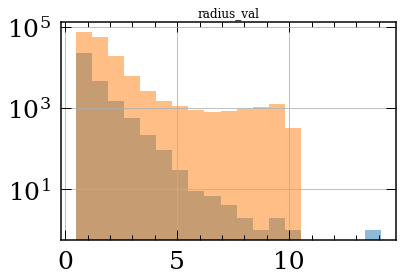

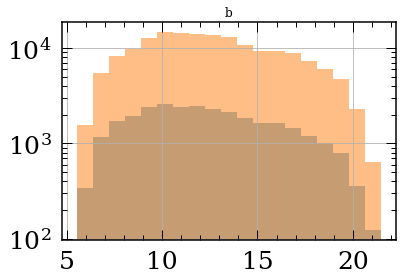

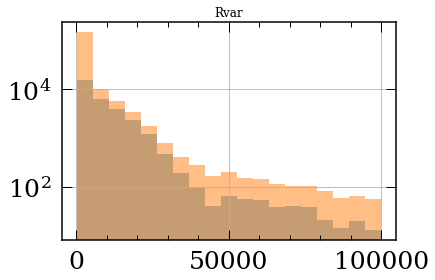

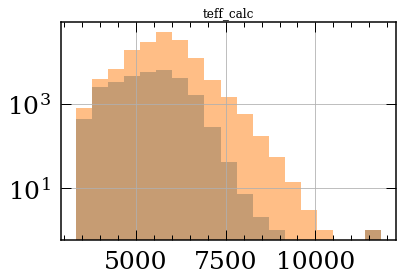

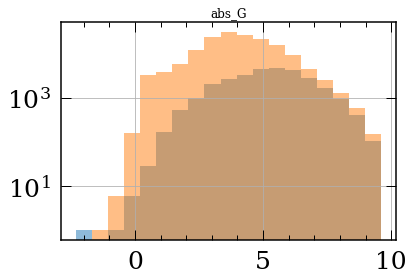

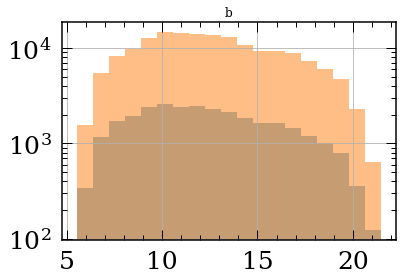

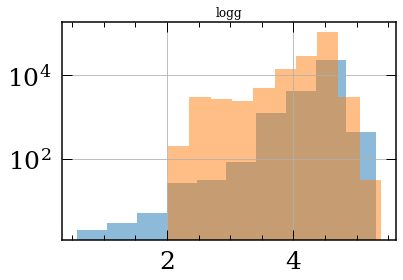

In [127]:
df_rvar=df_rvar.loc[df_rvar['radius_val']<10]
#df_rvar=df_rvar.loc[df_rvar['teff_calc']>3000]
#df_rvar=df_rvar.loc[df_rvar['teff_calc']<10000]
df_rvar=df_rvar.loc[df_rvar['Rvar']<1e5]
df_rvar=df_rvar.loc[df_rvar['logg']>2]
df_rvar=df_rvar.loc[df_rvar['v_t']<200]
df_rvar=df_rvar.loc[df_rvar['lum_val']<50]
df_rvar=df_rvar.loc[abs(df_rvar['v_b'])<100]
for i in np.append(regr_outs['actrualF'],['abs_G','b']):
    plt.figure()
    minbinsize=min(np.append(df_prot[i].values,df_rvar[i].values))
    maxbinsize=max(np.append(df_prot[i].values,df_rvar[i].values))
    bins=np.linspace(minbinsize,maxbinsize,20)
    df_prot[i].hist(alpha=0.5,bins=bins)
    df_rvar[i].hist(alpha=0.5,bins=bins)
    plt.yscale('log')
    plt.title(i)

plt.figure()
df_prot['logg'].hist(alpha=0.5)
df_rvar['logg'].hist(alpha=0.5)
plt.yscale('log')
plt.title('logg')

#df_rvar.to_pickle('KinageAllKepler_cut.pkl')

In [128]:
predictions_rvar=regr.predict(df_rvar[regr_outs['actrualF']].values)

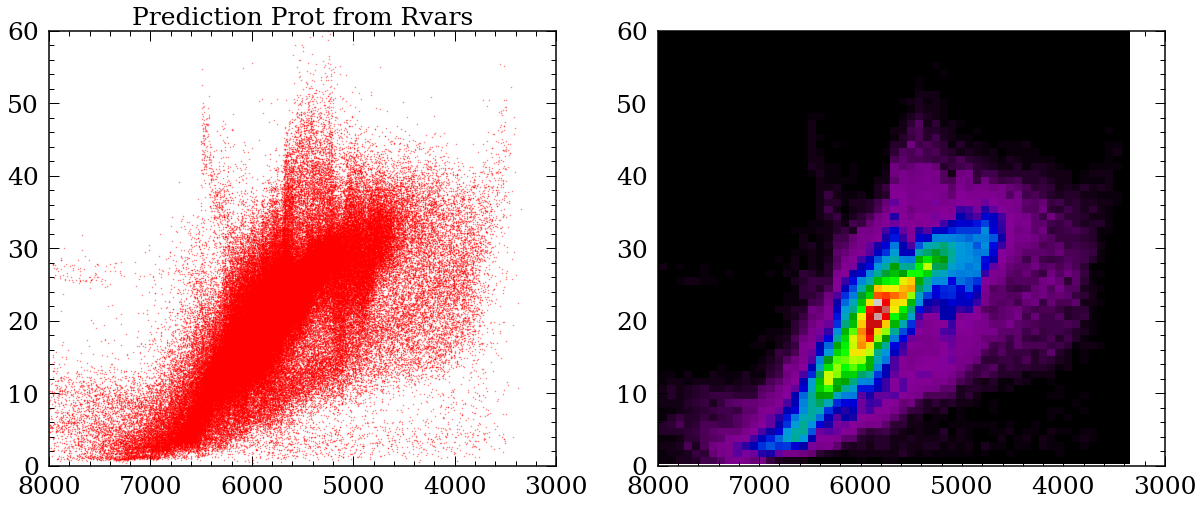

In [130]:
df_rvar['Prot_predict']=predictions_rvar

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df_rvar.teff_calc,predictions_rvar,'r.',alpha=0.5,markersize=1)
plt.gca().invert_xaxis()
plt.xlim([8000,3000])
plt.title('Prediction Prot from Rvars',fontsize=25)
plt.ylim([0,60])
plt.subplot(1,2,2)
plt.hist2d(df_rvar.teff_calc,predictions_rvar,bins =100,cmap = plt.cm.nipy_spectral)
plt.gca().invert_xaxis()
plt.xlim([8000,3000])
plt.ylim([0,60])

df_rvar.to_pickle('KinageAllKepler_cut.pkl')

plt.savefig('AstraeaMcQuillan_wRvar_allstars.png')

(-100, 100)

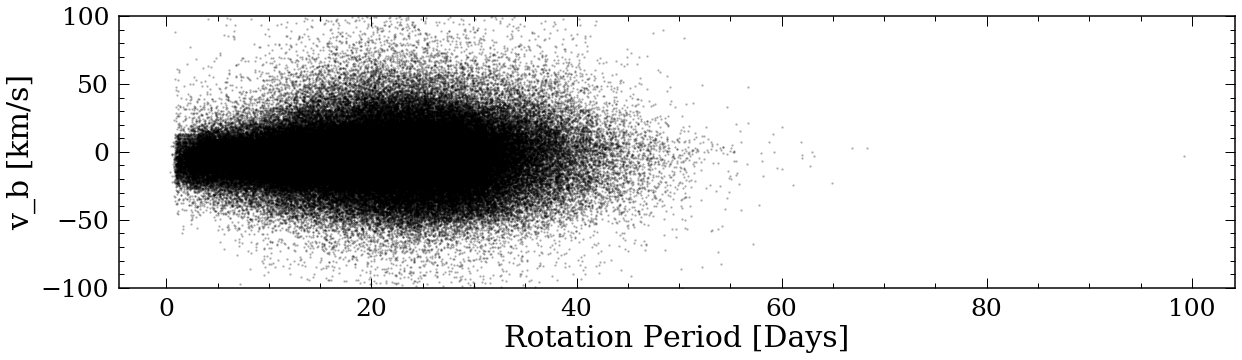

In [131]:
plt.figure(figsize=(20,5))
plt.plot(predictions_rvar,df_rvar['v_b'],'k.',alpha=0.2,markersize=3)
plt.xlabel('Rotation Period [Days]')
plt.ylabel('v_b [km/s]')
plt.ylim([-100,100])

KeyError: 'predictedProt'

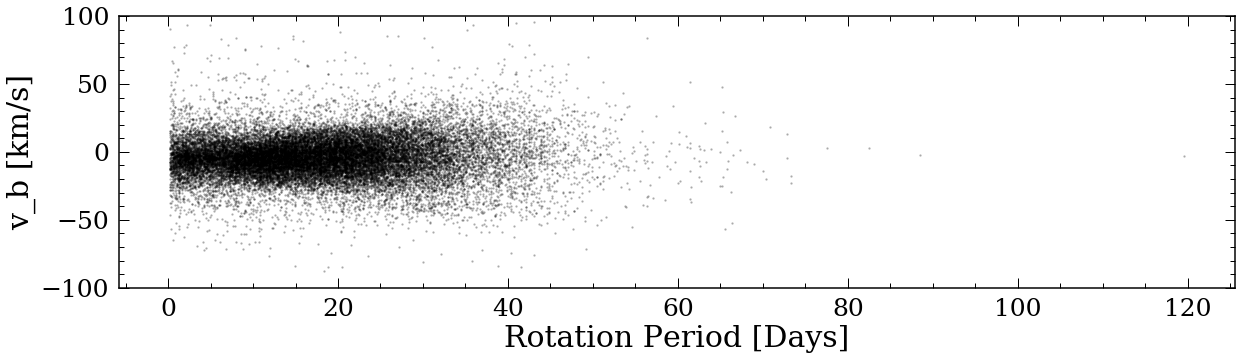

<Figure size 1440x360 with 0 Axes>

In [134]:
plt.figure(figsize=(20,5))
plt.plot(df_prot['Prot'],df_prot['v_b'],'k.',alpha=0.2,markersize=3)
plt.xlabel('Rotation Period [Days]')
plt.ylabel('v_b [km/s]')
plt.ylim([-100,100])



plt.figure(figsize=(20,5))
plt.plot(df_prot['predictedProt'],df_prot['v_b'],'k.',alpha=0.2,markersize=3)
plt.xlabel('Rotation Period [Days]')
plt.ylabel('v_b [km/s]')
plt.ylim([-100,100])


# Train on Rocio ages

In [106]:
with fits.open('M-WD-Prot/TESS_results_ages.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")

In [109]:
gaia['total_age_err_gyr']=(gaia['total_age_err_high_gyr']+gaia['total_age_err_low_gyr']-2.*gaia['total_age_median_gyr'])/2.




In [110]:
# Train
regr, regr_outs = Astraea.RFregressor(gaia, [i for i in gaia.columns if 'age' not in i],
                                      target_var='total_age_median_gyr', target_var_err='total_age_err_gyr', n_estimators=60)


Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 12
Features attempt to train: ['TIC', 'source_id_wd', 'teffH', 'teffH_e', 'loggH', 'loggH_e', 'initial_mass_median', 'initial_mass_err_low', 'initial_mass_err_high', 'final_mass_median', 'final_mass_err_low', 'final_mass_err_high']
ID column not found, using index as ID!
12 stars in dataframe!
12 total stars used for RF!
9 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.3169841344296678
Average chi^2 is: -8.77298471009197
Finished!


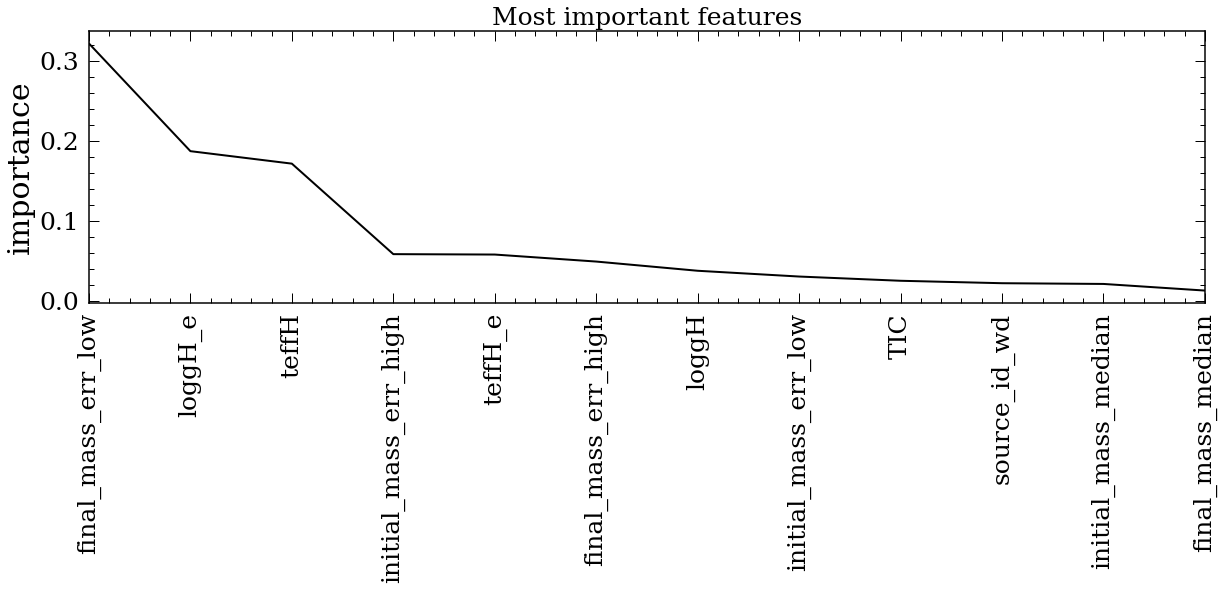

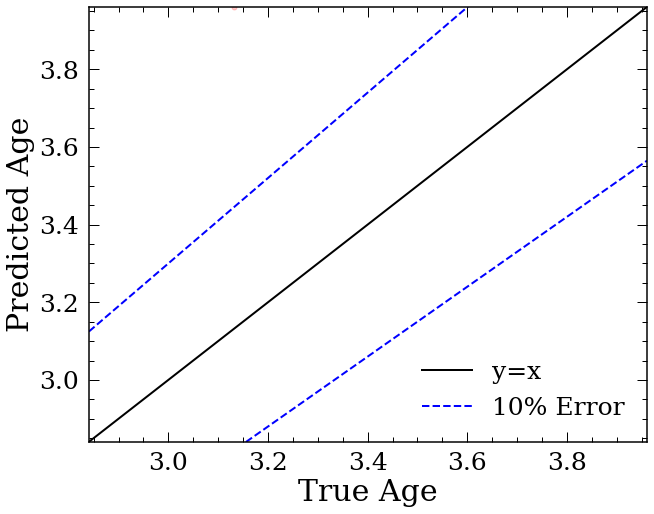

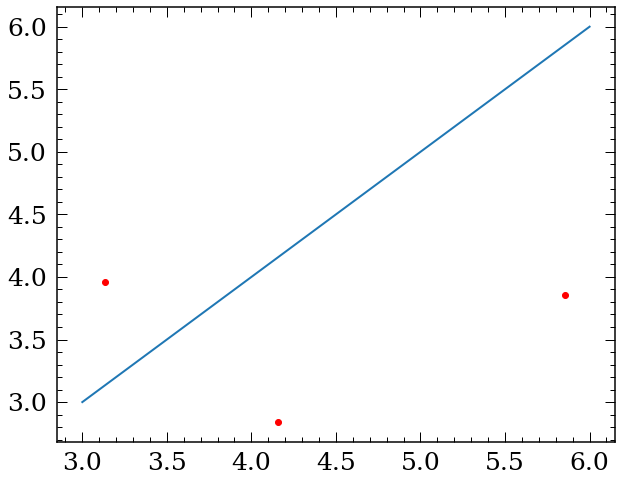

In [117]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Age', MS=10)

plt.figure(figsize=(10,8))
plt.plot(regr_outs['y_test'],regr_outs['prediction'],'ro')
plt.plot([3,6],[3,6])

In [195]:
df_rvar['Prot_predict']=predictions_rvar

Text(0, 0.5, 'Real Prot')

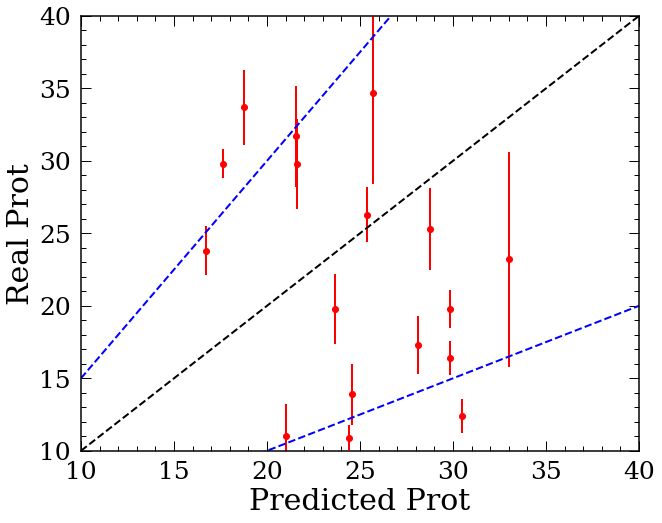

In [201]:
seismicKID=np.array([3427720,3656476,5184732,6116048,6196457,6521045,7680114,7871531,8006161,8349582,
           9098294,9139151,9955598,10454113,10586004,10644253,10963065,11244118,11401755])
seismicProt=np.array([23.8,23.2,13.9,31.7,19.8,17.3,16.4,25.3,26.3,33.7,29.8,51.0,19.8,11.0,34.7,14.6,
             29.8,10.91,12.4])
seismicProt_err=np.array([1.7,7.4,2.1,3.5,2.4,2.0,1.2,2.8,1.9,2.6,3.1,1.5,1.3,2.2,6.3,1.1,1.0,0.87,1.2])


seismicnew=df_rvar.loc[~df_rvar['KID'].isin(df_prot['KID'])]
seismicnew=seismicnew.loc[seismicnew['KID'].isin(seismicKID)]

mask=np.zeros(len(seismicKID), dtype=bool)
for i in range(len(seismicKID)):
    if seismicKID[i] in seismicnew['KID'].values:
        mask[i]=1


plt.figure(figsize=(10,8))        
plt.errorbar(seismicnew['Prot_predict'],seismicProt[mask],yerr=seismicProt_err[mask],fmt='ro')
lims=[10,40]
plt.plot(lims,lims,'k--')
plt.plot([lims[0],lims[1]],[lims[0]*1.5,lims[1]*1.5],'b--')
plt.plot([lims[0],lims[1]],[lims[0]*0.5,lims[1]*0.5],'b--')
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('Predicted Prot')
plt.ylabel('Real Prot')

In [3]:
prot_ages=pd.read_pickle('minchisq_rvar.pkl')
prot_ages=prot_ages.loc[prot_ages['KID'].isin(seismicKID)]
ages=[2.23,9.15,5.04,1.71,6.43,1.07]
ages_err=[0.17,0.47,0.17,0.19,0.47,0.25]
plt.figure(figsize=(10,8))        
plt.errorbar(prot_ages['kin_age'],ages,yerr=ages_err,xerr=prot_ages['kin_age_err_bs'],fmt='ro')
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Kin ages')
plt.ylabel('AS ages')

NameError: name 'seismicKID' is not defined

# McQ Tab2

In [4]:
df=pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_2_Non_Periodic.txt',delimiter=',')

In [5]:
df=df.dropna(subset=['Prot']).reset_index(drop=True)

In [6]:
df

,KID,Teff,logg,Mass,Prot,Prot_err,LPH,w,DC
0,1027110,4155,4.50,0.6046,1.701,0.039,0.299,0.1439,0
1,1027277,4326,4.57,0.6735,60.136,0.691,0.315,0.0876,0
2,1160684,3952,4.48,0.5239,0.419,0.090,0.150,0.0266,0
3,1161315,4247,4.59,0.6416,41.838,2.492,0.406,0.2434,0
4,1163114,4049,4.53,0.5622,0.766,0.167,0.217,0.0815,0
...,...,...,...,...,...,...,...,...,...
30749,12934488,5731,4.59,1.0281,51.754,0.849,0.507,0.2247,0
30750,12934771,4974,3.91,0.8275,60.106,4.700,0.117,0.0081,0
30751,12934955,5870,4.51,1.0680,57.268,6.512,0.525,0.2272,0
30752,12935010,4776,4.40,0.7756,29.986,3.730,0.269,0.1523,0


In [28]:
fname_bin='KinageAllKepler_cut.pkl'


df_bin_rotrvar=pd.read_pickle(fname_bin)
print(len(df_bin_rotrvar))

df_bin_rotrvar=df_bin_rotrvar.dropna(subset=['kin_age','kin_age_err'])

print(len(df_bin_rotrvar))

df_bin_rotrvar=df_bin_rotrvar.loc[df_bin_rotrvar['abs_G']>4]
print(len(df_bin_rotrvar))

154965
154965
75480


In [40]:
dfcm=pd.merge(df,df_bin_rotrvar[['KID','Prot_predict','teff_calc']],left_on='KID',right_on='KID',how='inner')
#dfcm=dfcm.loc[dfcm['w']>0.15]
print(len(dfcm))

13170


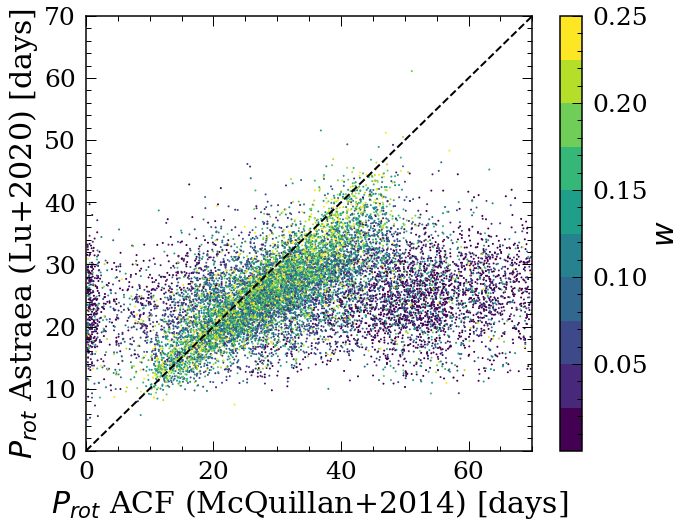

In [41]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(dfcm['Prot'],dfcm['Prot_predict'],c=dfcm['w'],s=1,cmap=cm)
plt.plot([0,70],[0,70],'k--')
plt.xlim([0,70])
plt.ylim([0,70])
plt.xlabel('$P_{rot}$ ACF (McQuillan+2014) [days]')
plt.ylabel('$P_{rot}$ Astraea (Lu+2020) [days]')
cb=plt.colorbar()
cb.set_label('$w$')
plt.savefig('Figures/McQTb2.png')

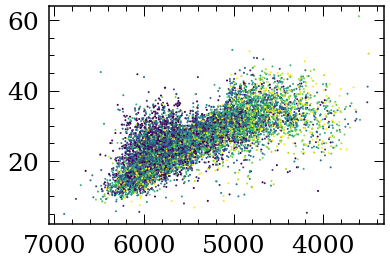

In [36]:
plt.scatter(dfcm['teff_calc'],dfcm['Prot_predict'],c=dfcm['w'],s=1,cmap=cm)
plt.gca().invert_xaxis()

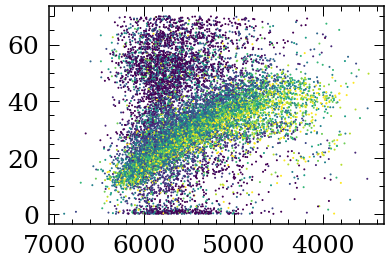

In [37]:
plt.scatter(dfcm['teff_calc'],dfcm['Prot'],c=dfcm['w'],s=1,cmap=cm)
plt.gca().invert_xaxis()